<a href="https://colab.research.google.com/github/GIJOE1003/3103ETF/blob/main/Notebook1_Future_Price_Prediction_03th_April.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETF Future Price Prediction

This notebook forecasts ETF closing prices 7 days ahead using multiple regression models.

In [15]:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



## Data Collection

In [14]:
# Data Collection
tickers = ['SPY', 'QQQ', 'GLD','TLT', 'VTI','EEM','XLF','XLV','VEA','VNQ']
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(months=120)

# Download prices
df_raw = yf.download(tickers, start=start_date, end=end_date)

df_open = df_raw['Open'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Open')
df_close = df_raw['Close'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
df_high  = df_raw['High'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='High')
df_low   = df_raw['Low'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Low')
df_volume = df_raw['Volume'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Volume')

# Merge into one DataFrame
df = df_open.merge(df_close, on=['Date', 'Ticker']).merge(df_high, on=['Date', 'Ticker']).merge(df_low, on=['Date', 'Ticker']).merge(df_volume, on=['Date', 'Ticker'])
df = df.round(2)

# Create CSV File
df.to_csv("combined_etf_data.csv", index = False)
print(f"Combined data saved: {df.shape}")
print(df.head())
print(df.tail())

df.isnull().sum()
df.info()


[*********************100%***********************]  10 of 10 completed


Combined data saved: (25160, 7)
        Date Ticker   Open  Close   High    Low    Volume
0 2015-04-13    EEM  34.45  34.18  34.57  34.17  55031100
1 2015-04-14    EEM  34.26  34.34  34.41  34.11  42601100
2 2015-04-15    EEM  34.33  34.58  34.59  34.26  40254700
3 2015-04-16    EEM  34.67  34.85  35.05  34.62  55057700
4 2015-04-17    EEM  34.12  34.24  34.30  34.04  76688000
            Date Ticker    Open   Close    High     Low    Volume
25155 2025-04-04    XLV  141.14  135.28  141.71  135.23  21341100
25156 2025-04-07    XLV  131.71  134.47  137.37  129.66  29940300
25157 2025-04-08    XLV  139.43  132.98  139.44  131.28  20860400
25158 2025-04-09    XLV  130.13  138.76  139.24  129.68  39444700
25159 2025-04-10    XLV  137.70  134.89  137.74  131.33  21956900
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    25160 non-null 

# EDA (Exploratory Data Analysis)

In [5]:
#Summary Stats
summary = df.groupby("Ticker")["Close"].describe()
summary = summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary=summary.round(2)
display(summary)


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
EEM,2516.0,37.66,5.92,23.18,34.26,37.64,41.23,52.82
GLD,2516.0,154.68,39.54,100.50,120.82,153.82,177.49,292.35
QQQ,2516.0,248.54,123.42,89.91,140.01,215.26,345.74,538.72
SPY,2516.0,324.00,120.94,156.33,221.82,290.03,413.06,611.09
TLT,2516.0,107.06,16.76,77.92,95.29,101.95,119.80,150.87
VEA,2516.0,37.58,7.01,24.41,32.41,36.10,43.46,52.75
VNQ,2516.0,71.61,12.85,47.02,60.92,70.57,80.90,101.98
VTI,2516.0,163.84,59.03,79.19,113.65,147.05,209.09,302.06
XLF,2516.0,27.79,9.00,13.39,21.18,25.10,34.12,52.00


<Figure size 1400x700 with 0 Axes>

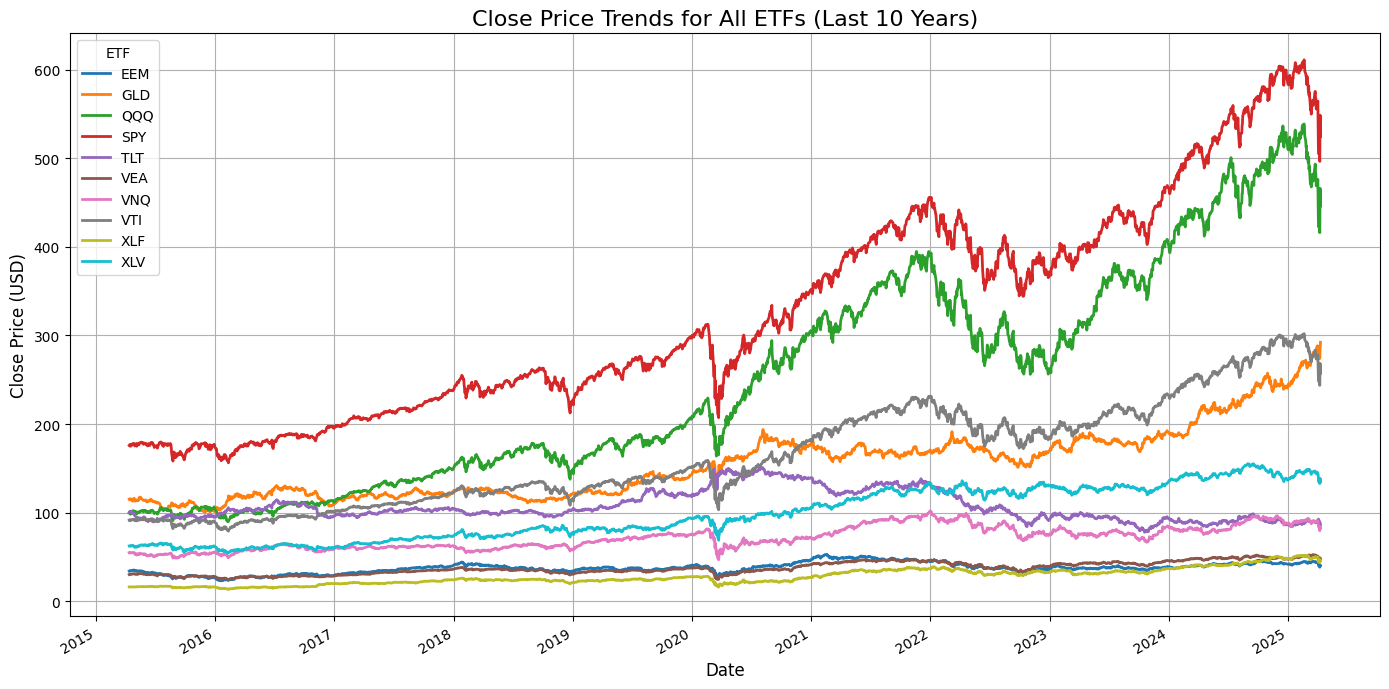

In [19]:
df['Date'] = pd.to_datetime(df['Date'])

last_10yrs = df[df['Date'] >= df['Date'].max() - pd.DateOffset(years=10)]
pivot_df = last_10yrs.pivot(index='Date', columns='Ticker', values='Close')

plt.figure(figsize=(14, 7))
pivot_df.plot(figsize=(14, 7), linewidth=2)

plt.title("Close Price Trends for All ETFs (Last 10 Years)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price (USD)", fontsize=12)
plt.legend(title="ETF", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Engineering

In [16]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change().round(4)
df['Return'] = df['Return'].fillna(0.0)
df['Volatility7'] = df.groupby('Ticker')['Return'].rolling(window=20).std().reset_index(level=0, drop=True).round(4)
df['Volatility7'] = df['Volatility7'].fillna(0.0)


df['MA5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean()).round(4)
df['Close_MA5_diff'] = ((df['Close'] - df['MA5']) / df['MA5'] * 100).round(4)

windows = [20, 50, 200]
for w in windows:
    df[f'SMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(w).mean()).round(4)
    df[f'EMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=w, adjust=False).mean()).round(4)


df['PrevClose'] = df.groupby('Ticker')['Close'].shift(1)
df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)
df['ATR7'] = df.groupby('Ticker')['TR'].transform(lambda x: x.rolling(7).mean()).round(4)
df['ATR7_pct'] = (df['ATR7'] / df['Close'] * 100).round(4)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)

ema_12 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema_26 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

df['MACD'] = (ema_12 - ema_26).round(4)
df['Signal_Line'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean()).round(4)

low14 = df.groupby('Ticker')['Low'].transform(lambda x: x.rolling(14).min())
high14 = df.groupby('Ticker')['High'].transform(lambda x: x.rolling(14).max())

df['%K'] = ((df['Close'] - low14) / (high14 - low14) * 100).round(2)
df['%D'] = df.groupby('Ticker')['%K'].transform(lambda x: x.rolling(3).mean())

df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['IsMonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end.astype(int)


df.to_csv("combined_etf_data_features.csv", index = False)
print(f"Combined data saved: {df.shape}")

<ipython-input-16-c7f3bfe94bce>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)


Combined data saved: (25160, 29)


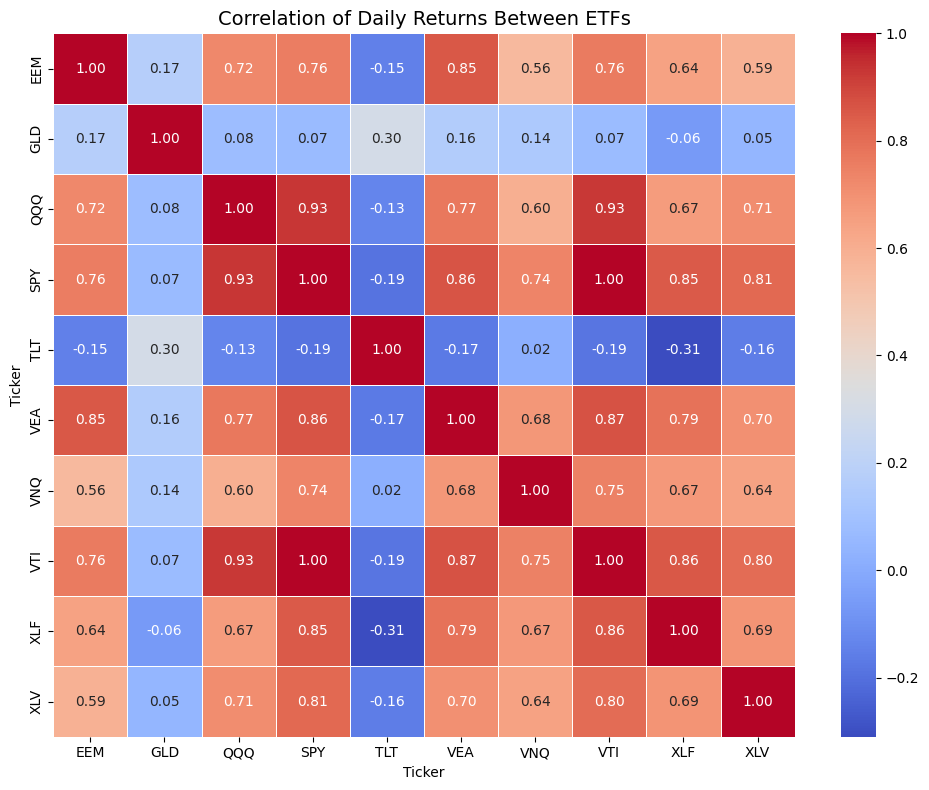

In [21]:
#correlation between tickers

returns_matrix = df.pivot(index='Date', columns='Ticker', values='Return')
returns_matrix = returns_matrix.dropna()
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation of Daily Returns Between ETFs", fontsize=14)
plt.tight_layout()
plt.show()



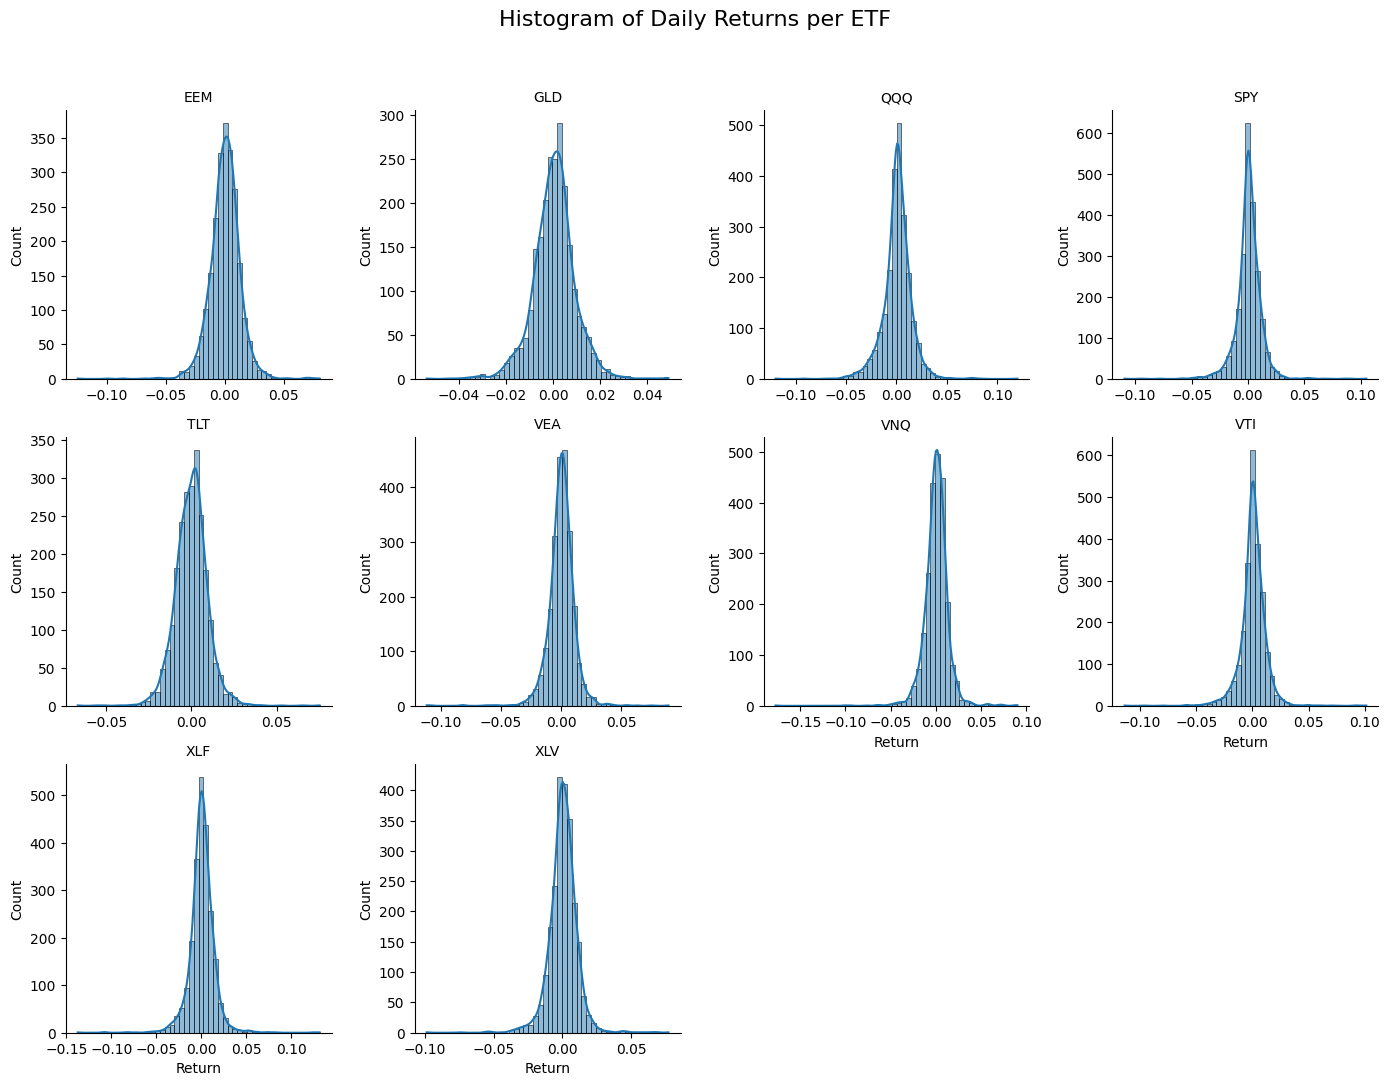

In [22]:
g = sns.FacetGrid(df.dropna(), col="Ticker", col_wrap=4, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="Return", bins=50, kde=True)
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Histogram of Daily Returns per ETF", y=1.03, fontsize=16)
plt.tight_layout()
plt.show()


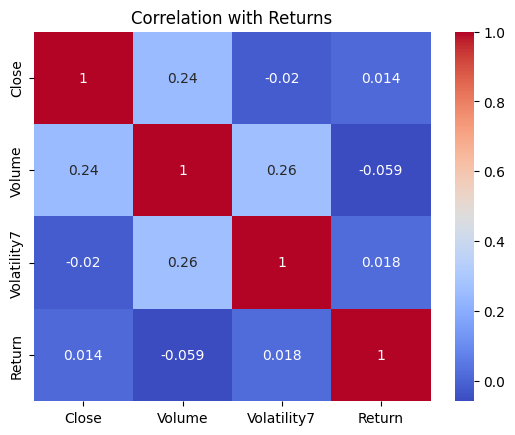

In [23]:
# 14. Feature Correlation with Return
corr_features = df[['Close', 'Volume', 'Volatility7', 'Return']].corr()
sns.heatmap(corr_features, annot=True, cmap='coolwarm')
plt.title("Correlation with Returns")
plt.show()


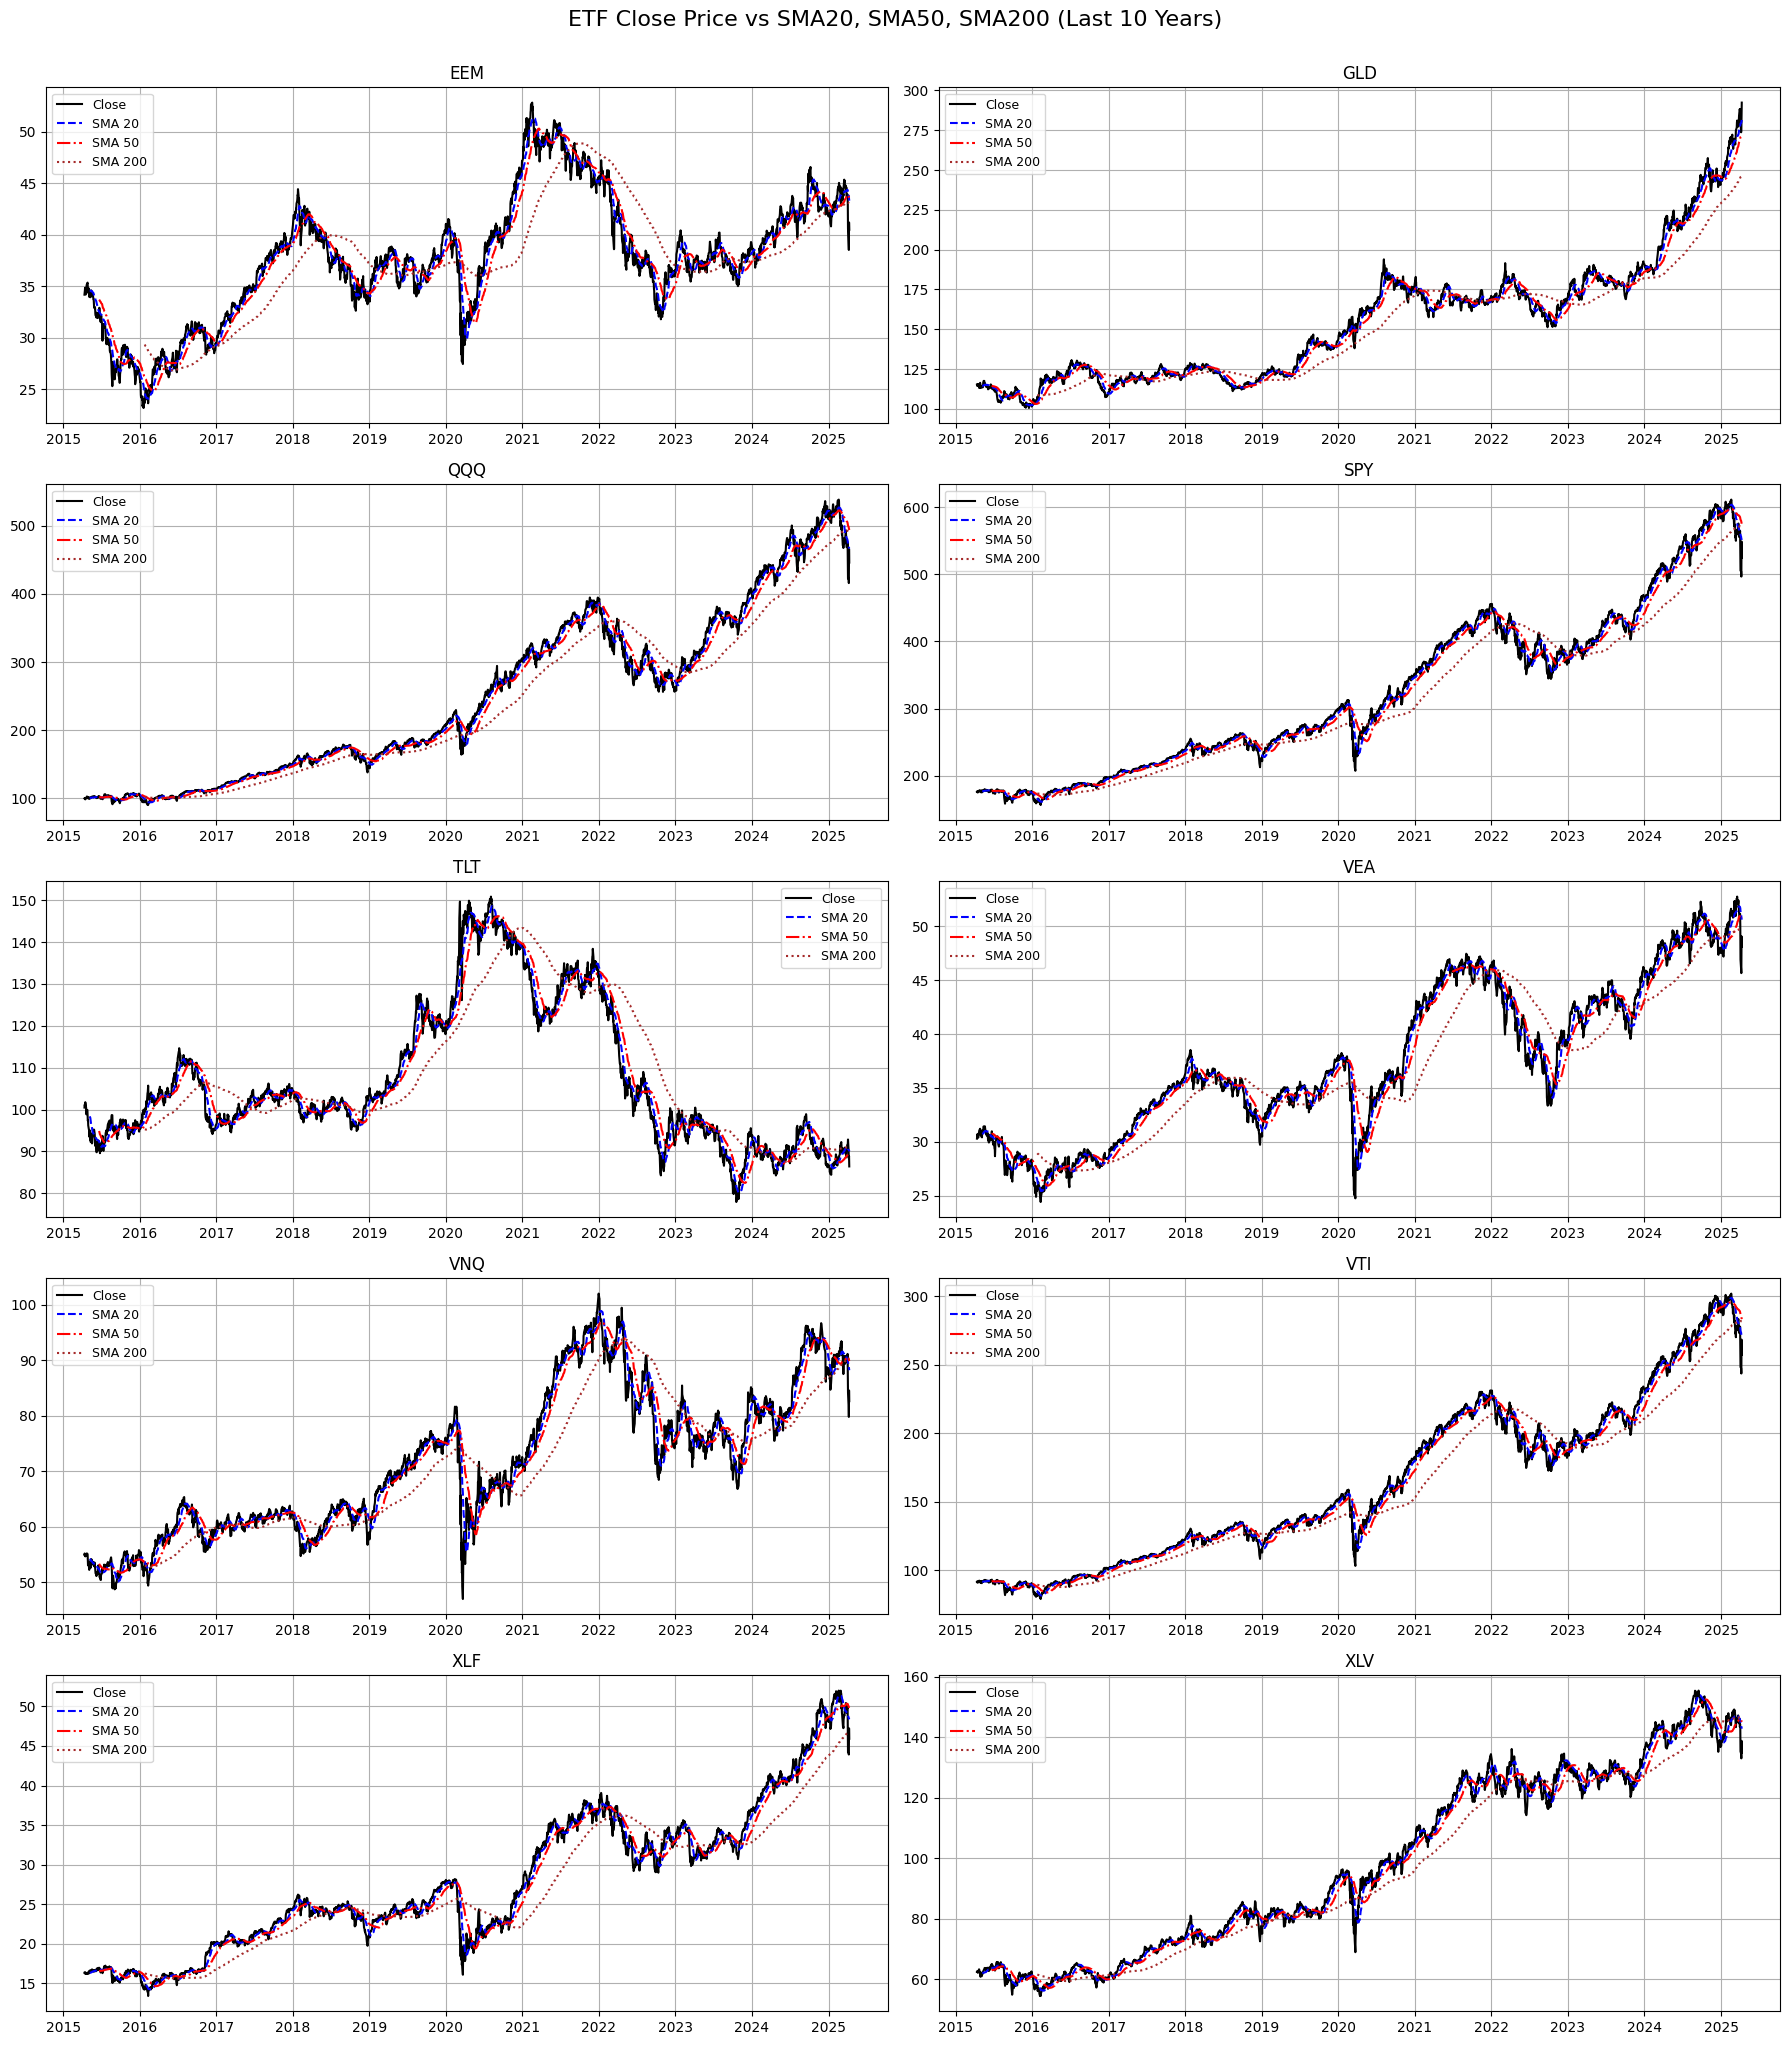

In [24]:
import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'])
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(years=10)


df_10yr = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
etfs = sorted(df_10yr['Ticker'].unique())

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), sharex=False)
axs = axs.flatten()

for i, ticker in enumerate(etfs):
    ax = axs[i]
    df_ticker = df_10yr[df_10yr['Ticker'] == ticker].sort_values('Date')

    ax.plot(df_ticker['Date'], df_ticker['Close'], label='Close', color='black')
    ax.plot(df_ticker['Date'], df_ticker['SMA20'], label='SMA 20',color='blue', linestyle='--')
    ax.plot(df_ticker['Date'], df_ticker['SMA50'], label='SMA 50', color = 'red',linestyle='-.')
    ax.plot(df_ticker['Date'], df_ticker['SMA200'], label='SMA 200',color ='brown', linestyle=':')

    ax.set_title(f'{ticker}', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
fig.suptitle("ETF Close Price vs SMA20, SMA50, SMA200 (Last 10 Years)", fontsize=16, y=1.02)
plt.show()


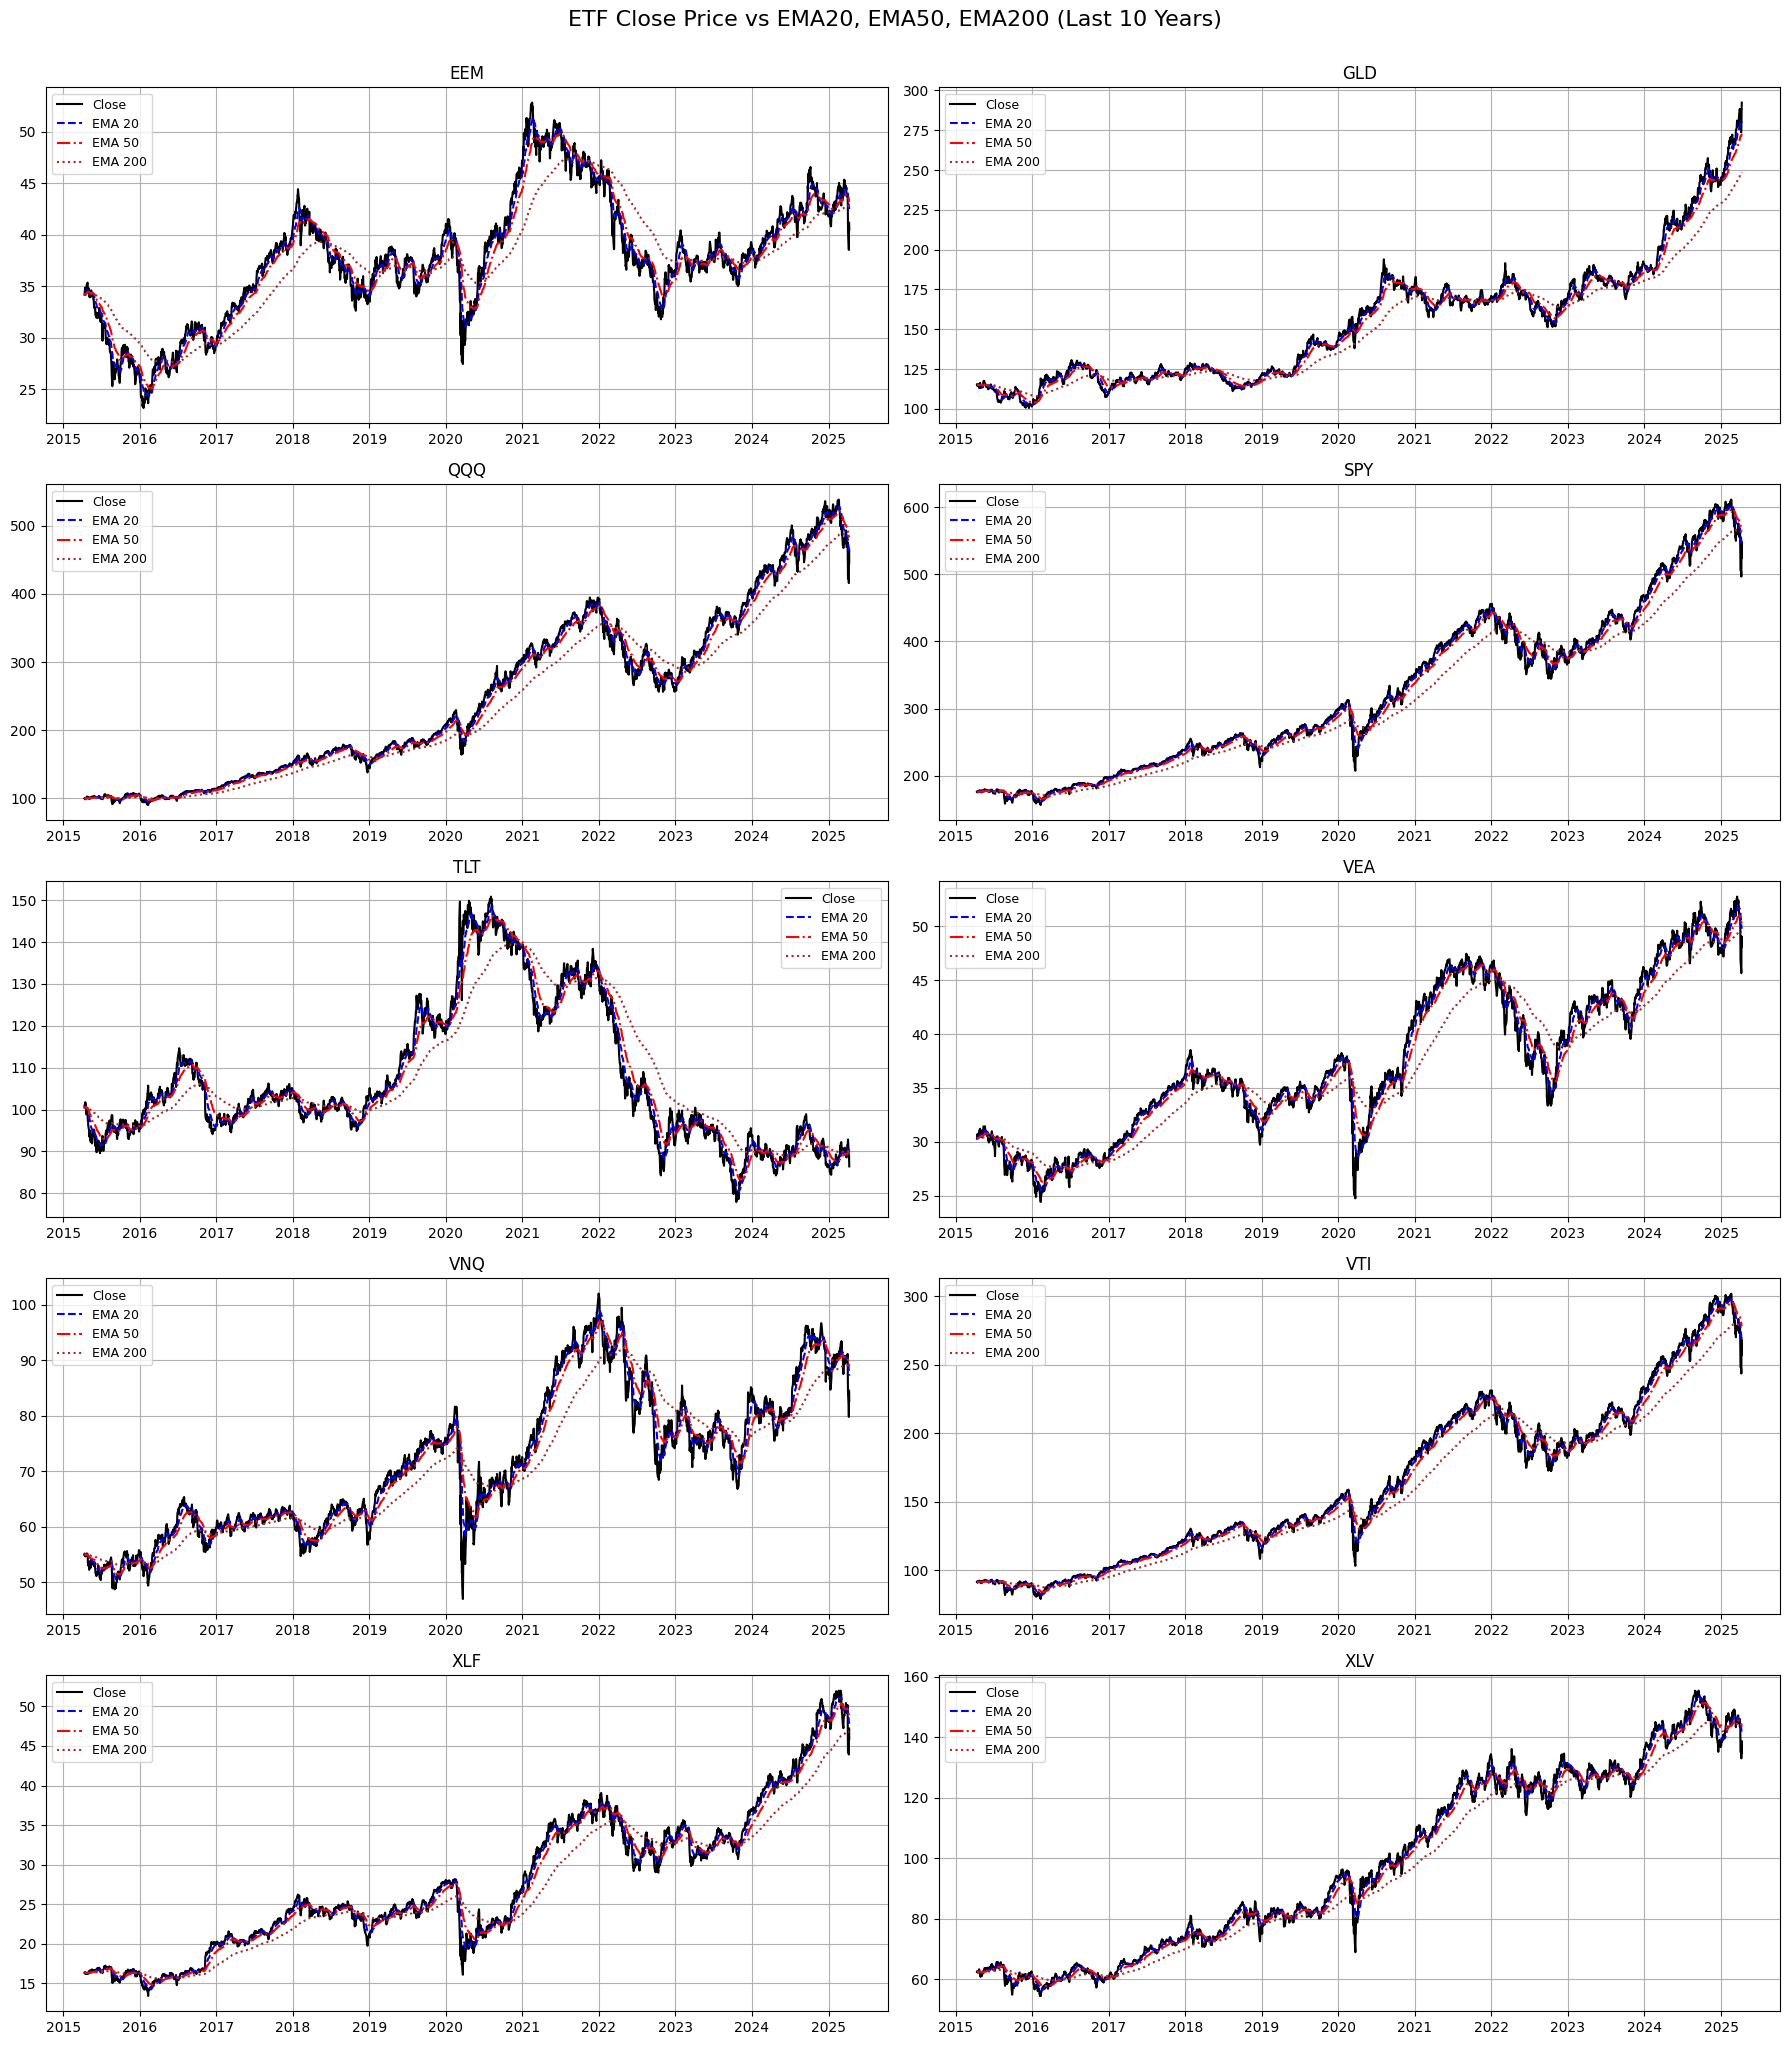

In [25]:
import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'])
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(years=10)


df_10yr = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
etfs = sorted(df_10yr['Ticker'].unique())

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), sharex=False)
axs = axs.flatten()

for i, ticker in enumerate(etfs):
    ax = axs[i]
    df_ticker = df_10yr[df_10yr['Ticker'] == ticker].sort_values('Date')

    ax.plot(df_ticker['Date'], df_ticker['Close'], label='Close', color='black')
    ax.plot(df_ticker['Date'], df_ticker['EMA20'], label='EMA 20',color='blue', linestyle='--')
    ax.plot(df_ticker['Date'], df_ticker['EMA50'], label='EMA 50', color = 'red',linestyle='-.')
    ax.plot(df_ticker['Date'], df_ticker['EMA200'], label='EMA 200',color ='brown', linestyle=':')

    ax.set_title(f'{ticker}', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
fig.suptitle("ETF Close Price vs EMA20, EMA50, EMA200 (Last 10 Years)", fontsize=16, y=1.02)
plt.show()

In [17]:

# Basic features
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Future_Close'] = df.groupby('Ticker')['Close'].shift(-7)
df.dropna(inplace=True)

features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7','RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']
X = df[features]
y = df['Future_Close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


### Linear Regression

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")

y_train_lr = lr.predict(X_train)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
mae_lr_train = mean_absolute_error(y_train, lr.predict(X_train))
r2_lr_train = r2_score(y_train, lr.predict(X_train))

print(f"Linear Regression - Train RMSE: {rmse_lr_train:.4f}, MAE: {mae_lr_train:.4f}, R2: {r2_lr_train:.4f}")
print (f"Linear Regression - Test RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")



Linear Regression - RMSE: 1.9942, MAE: 1.3523, R2: 0.9978
Linear Regression - Train RMSE: 5.5013, MAE: 3.1324, R2: 0.9979
Linear Regression - Test RMSE: 1.9942, MAE: 1.3523, R2: 0.9978


### Random Forest Regression

In [20]:

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")

y_train_rf = rf.predict(X_train)
rmse_rf_train = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
mae_rf_train = mean_absolute_error(y_train, rf.predict(X_train))
r2_rf_train = r2_score(y_train, rf.predict(X_train))

print(f"Random Forest - Train RMSE: {rmse_rf_train:.4f}, MAE: {mae_rf_train:.4f}, R2: {r2_rf_train:.4f}")
print (f"Random Forest - Test RMSE: {rmse_rf:.4f}", "MAE:", mae_rf, "R²:", r2_rf)


Random Forest - RMSE: 3.9775, MAE: 2.8243, R2: 0.9911
Random Forest - Train RMSE: 1.1390, MAE: 0.5950, R2: 0.9999
Random Forest - Test RMSE: 3.9775 MAE: 2.824312056277061 R²: 0.9911209866531093


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt','log2',None]
}

# Perform grid search
rf_grid = RandomizedSearchCV(RandomForestRegressor(), rf_param_grid, cv=2, n_iter=20, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_grid.fit(X_train, y_train)


# Best model
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)

# Evaluation
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

y_train_rf_best = rf_best.predict(X_train)
rmse_rf_best_train = np.sqrt(mean_squared_error(y_train, rf_best.predict(X_train)))
mae_rf_best_train = mean_absolute_error(y_train, rf_best.predict(X_train))
r2_rf_best_train = r2_score(y_train, rf_best.predict(X_train))

print(f"Random Forest (Tuned) - Train RMSE: {rmse_rf_best_train:.4f}, MAE: {mae_rf_best_train:.4f}, R2: {r2_rf_best_train:.4f}")
print("Random Forest (Tuned) - RMSE:", rmse_rf_best, "MAE:", mae_rf_best, "R²:", r2_rf_best)
print("Best Params:", rf_grid.best_params_)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Random Forest (Tuned) - Train RMSE: 1.0169, MAE: 0.5461, R2: 0.9999
Random Forest (Tuned) - RMSE: 2.9561141394606953 MAE: 1.5469114285714263 R²: 0.9993417150539889
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': None}


### XGBoost Regression

In [22]:

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)


y_pred_xgb_train = xgb.predict(X_train)
rmse_xgb_train = np.sqrt(mean_squared_error(y_train, xgb.predict(X_train)))
mae_xgb_train = mean_absolute_error(y_train, xgb.predict(X_train))
r2_xgb_train = r2_score(y_train, xgb.predict(X_train))

print(f"XGBoost - Train RMSE: {rmse_xgb_train:.4f}, MAE: {mae_xgb_train:.4f}, R2: {r2_xgb_train:.4f}")
print(f"XGBoost - RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}")



XGBoost - Train RMSE: 1.7445, MAE: 1.2482, R2: 0.9998
XGBoost - RMSE: 3.6149, MAE: 2.1293, R2: 0.9990


In [23]:
from sklearn.model_selection import RandomizedSearchCV

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_2d = X_train.values.reshape(X_train.shape[0], -1)
X_test_2d = X_test.values.reshape(X_test.shape[0], -1)

xgb_grid = RandomizedSearchCV(XGBRegressor(), xgb_param_grid, cv=3, n_iter=20, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
xgb_grid.fit(X_train_2d, y_train)

xgb_best = xgb_grid.best_estimator_
y_pred_xgb_best = xgb_best.predict(X_test_2d)

rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

#test
y_pred_xgb_best_train = xgb_best.predict(X_train_2d)
rmse_xgb_best_train = np.sqrt(mean_squared_error(y_train, xgb_best.predict(X_train_2d)))
mae_xgb_best_train = mean_absolute_error(y_train, xgb_best.predict(X_train_2d))
r2_xgb_best_train = r2_score(y_train, xgb_best.predict(X_train_2d))

print(f"XGBoost (Tuned) - Train RMSE: {rmse_xgb_best_train:.4f}, MAE: {mae_xgb_best_train:.4f}, R2: {r2_xgb_best_train:.4f}")
print("XGBoost (Tuned) - RMSE:", rmse_xgb_best, "MAE:", mae_xgb_best, "R²:", r2_xgb_best)
print("Best Params:", xgb_grid.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost (Tuned) - Train RMSE: 0.3060, MAE: 0.2136, R2: 1.0000
XGBoost (Tuned) - RMSE: 3.165321929367931 MAE: 1.6844940810595759 R²: 0.9992452427399653
Best Params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


### LSTM Regression

In [25]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lookback = 21
forecast_horizon = 7

features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D', 'DayOfWeek', 'Month', 'IsMonthEnd']

results = []

for ticker in df['Ticker'].unique():
    print(f"\n LSTM (Return → Price) for {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)

    df_ticker['Raw_Close'] = df_ticker['Close']
    df_ticker['Future_Return'] = (
        df_ticker['Raw_Close'].shift(-forecast_horizon) - df_ticker['Raw_Close']
    ) / df_ticker['Raw_Close']
    df_ticker['Current_Price'] = df_ticker['Raw_Close']
    df_ticker.dropna(inplace=True)

    scaler = StandardScaler()
    df_ticker[features] = scaler.fit_transform(df_ticker[features])

    X, y, current_prices = [], [], []
    for i in range(lookback, len(df_ticker)):
        X.append(df_ticker[features].iloc[i - lookback:i].values)
        y.append(df_ticker['Future_Return'].iloc[i])
        current_prices.append(df_ticker['Current_Price'].iloc[i])

    X, y, current_prices = np.array(X), np.array(y), np.array(current_prices)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    current_price_train = current_prices[:split]
    current_price_test = current_prices[split:]

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(lookback, len(features))),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=30, batch_size=32,
              validation_split=0.1, callbacks=[early_stop], verbose=0)

    # Test
    y_pred_return_test = model.predict(X_test).flatten()
    y_pred_price_test = current_price_test * (1 + y_pred_return_test)
    y_test_price = current_price_test * (1 + y_test)

    # Train
    y_pred_return_train = model.predict(X_train).flatten()
    y_pred_price_train = current_price_train * (1 + y_pred_return_train)
    y_train_price = current_price_train * (1 + y_train)

    # Evaluation - Test
    rmse_test = np.sqrt(mean_squared_error(y_test_price, y_pred_price_test))
    mae_test = mean_absolute_error(y_test_price, y_pred_price_test)
    r2_test = r2_score(y_test_price, y_pred_price_test)

    # Evaluation - Train
    rmse_train = np.sqrt(mean_squared_error(y_train_price, y_pred_price_train))
    mae_train = mean_absolute_error(y_train_price, y_pred_price_train)
    r2_train = r2_score(y_train_price, y_pred_price_train)

    print(f"Train RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}, R²: {r2_train:.4f}")
    print(f"Test RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.4f}")
    print(f" y_test_price min/max: {y_test_price.min():.2f} / {y_test_price.max():.2f}")
    print(f" y_pred_price min/max: {y_pred_price_test.min():.2f} / {y_pred_price_test.max():.2f}")
    print(f" Sample y_test_price[:5]: {y_test_price[:5]}")
    print(f" Sample y_pred_price[:5]: {y_pred_price_test[:5]}")

    results.append((ticker, rmse_train, mae_train, r2_train, rmse_test, mae_test, r2_test))

# Final summary
results_df = pd.DataFrame(results, columns=["Ticker", "Train_RMSE", "Train_MAE", "Train_R2", "Test_RMSE", "Test_MAE", "Test_R2"]).sort_values("Test_RMSE")
display(results_df)



 LSTM (Return → Price) for EEM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train RMSE: 1.23, MAE: 0.92, R²: 0.9546
Test RMSE: 1.59, MAE: 1.34, R²: 0.6579
 y_test_price min/max: 35.01 / 46.57
 y_pred_price min/max: 36.19 / 46.83
 Sample y_test_price[:5]: [37.93 37.77 38.03 38.21 38.28]
 Sample y_pred_price[:5]: [37.10169858 37.75704988 36.99746781 36.5570717  36.93188682]

 LSTM (Return → Price) for GLD


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train RMSE: 3.71, MAE: 2.90, R²: 0.9772
Test RMSE: 9.06, MAE: 6.71, R²: 0.9157
 y_test_price min/max: 168.83 / 288.14
 y_pred_price min/max: 174.46 / 283.86
 Sample y_test_price[:5]: [182.34 180.15 182.53 182.04 181.88]
 Sample y_pred_price[:5]: [179.87824988 181.55194477 182.50832624 182.8327324  183.50141181]

 LSTM (Return → Price) for QQQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train RMSE: 8.63, MAE: 6.08, R²: 0.9898
Test RMSE: 19.13, MAE: 15.11, R²: 0.8849
 y_test_price min/max: 340.26 / 538.72
 y_pred_price min/max: 342.38 / 519.06
 Sample y_test_price[:5]: [350.34 344.4  348.67 350.01 355.92]
 Sample y_pred_price[:5]: [345.79124267 354.45890199 354.84122306 352.95002704 352.86056689]

 LSTM (Return → Price) for SPY


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train RMSE: 7.50, MAE: 5.15, R²: 0.9915
Test RMSE: 18.18, MAE: 14.39, R²: 0.9139
 y_test_price min/max: 402.63 / 611.09
 y_pred_price min/max: 403.04 / 616.48
 Sample y_test_price[:5]: [416.62 415.18 417.69 418.44 422.23]
 Sample y_pred_price[:5]: [403.04275373 408.59123724 408.433514   405.82510139 408.62541555]

 LSTM (Return → Price) for TLT


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train RMSE: 2.54, MAE: 1.90, R²: 0.9748
Test RMSE: 3.62, MAE: 3.02, R²: 0.1728
 y_test_price min/max: 77.92 / 98.90
 y_pred_price min/max: 79.58 / 96.46
 Sample y_test_price[:5]: [95.29 93.88 94.97 94.84 95.12]
 Sample y_pred_price[:5]: [91.25276466 91.9928403  93.06925304 93.73826428 93.65919744]

 LSTM (Return → Price) for VEA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Train RMSE: 0.94, MAE: 0.70, R²: 0.9708
Test RMSE: 1.91, MAE: 1.54, R²: 0.6460
 y_test_price min/max: 39.54 / 52.75
 y_pred_price min/max: 39.57 / 52.09
 Sample y_test_price[:5]: [43.14 42.73 43.17 43.15 43.35]
 Sample y_pred_price[:5]: [41.71987053 42.12575696 41.84872646 41.33130737 41.88238312]

 LSTM (Return → Price) for VNQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train RMSE: 2.54, MAE: 1.76, R²: 0.9525
Test RMSE: 3.17, MAE: 2.49, R²: 0.8147
 y_test_price min/max: 66.82 / 96.66
 y_pred_price min/max: 67.30 / 96.78
 Sample y_test_price[:5]: [75.68 77.07 76.59 76.15 76.17]
 Sample y_pred_price[:5]: [73.58563508 74.68645025 74.42891022 74.34893921 74.07582545]

 LSTM (Return → Price) for VTI


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train RMSE: 4.05, MAE: 2.84, R²: 0.9903
Test RMSE: 19.62, MAE: 16.41, R²: 0.5804
 y_test_price min/max: 198.87 / 302.06
 y_pred_price min/max: 197.07 / 279.75
 Sample y_test_price[:5]: [207.11 206.7  207.67 207.9  209.76]
 Sample y_pred_price[:5]: [197.57218961 199.86357787 199.66739699 198.8683034  199.77980322]

 LSTM (Return → Price) for XLF


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Train RMSE: 1.12, MAE: 0.85, R²: 0.9670
Test RMSE: 2.57, MAE: 1.91, R²: 0.8285
 y_test_price min/max: 30.70 / 52.00
 y_pred_price min/max: 30.05 / 59.27
 Sample y_test_price[:5]: [31.96 32.09 32.06 32.07 32.06]
 Sample y_pred_price[:5]: [30.30789731 30.60784279 30.52618106 30.0528259  30.18231868]

 LSTM (Return → Price) for XLV


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train RMSE: 2.61, MAE: 1.93, R²: 0.9880
Test RMSE: 5.01, MAE: 3.84, R²: 0.6713
 y_test_price min/max: 120.21 / 155.35
 y_pred_price min/max: 121.31 / 151.49
 Sample y_test_price[:5]: [125.58 125.09 125.89 126.28 126.73]
 Sample y_pred_price[:5]: [123.04221106 122.84087392 121.47352451 122.74386644 123.62125054]


,Ticker,Train_RMSE,Train_MAE,Train_R2,Test_RMSE,Test_MAE,Test_R2
0,EEM,1.225666,0.923846,0.954592,1.587295,1.335988,0.657944
5,VEA,0.936451,0.700404,0.970825,1.908174,1.539583,0.645990
8,XLF,1.116741,0.847636,0.966997,2.574141,1.909126,0.828511
6,VNQ,2.540089,1.760170,0.952453,3.166577,2.494761,0.814684
4,TLT,2.542834,1.903465,0.974808,3.622145,3.021885,0.172760
9,XLV,2.610116,1.929616,0.988022,5.010746,3.844485,0.671282
1,GLD,3.709607,2.902787,0.977236,9.059119,6.705613,0.915684
3,SPY,7.504930,5.150525,0.991517,18.176624,14.387045,0.913934
2,QQQ,8.634316,6.076540,0.989808,19.128853,15.107608,0.884914
7,VTI,4.052041,2.843362,0.990253,19.622868,16.410168,0.580436


In [26]:
pip install keras_tuner

In [27]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


lookback = 21
forecast_horizon = 7

# Feature
features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D',
    'DayOfWeek', 'Month', 'IsMonthEnd']

results = []

# Define
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('lstm_units', 32, 128, step=32),
        return_sequences=False,
        input_shape=(lookback, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    return model

for ticker in df['Ticker'].unique():
    print(f"\n Tuning LSTM (Return → Price) for: {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)

    # compute return
    df_ticker['Raw_Close'] = df_ticker['Close']
    df_ticker['Future_Return'] = (
        df_ticker['Raw_Close'].shift(-forecast_horizon) - df_ticker['Raw_Close']
    ) / df_ticker['Raw_Close']
    df_ticker['Current_Price'] = df_ticker['Raw_Close']
    df_ticker.dropna(inplace=True)

    # Scale features
    scaler = StandardScaler()
    df_ticker[features] = scaler.fit_transform(df_ticker[features])

    # Create sequences
    X, y, current_prices = [], [], []
    for i in range(lookback, len(df_ticker)):
        X.append(df_ticker[features].iloc[i - lookback:i].values)
        y.append(df_ticker['Future_Return'].iloc[i])
        current_prices.append(df_ticker['Current_Price'].iloc[i])

    X, y, current_prices = np.array(X), np.array(y), np.array(current_prices)
    split = int(0.8 * len(X))
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]
    current_price_val = current_prices[split:]

    # Tune using Keras Tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        overwrite=True,
        directory=f'tuning_dir_{ticker}',
        project_name=f'{ticker}_lstm_return'
    )

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    tuner.search(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=25, batch_size=32,
                 callbacks=[early_stop], verbose=0)

    best_model = tuner.get_best_models(1)[0]
    best_hps = tuner.get_best_hyperparameters(1)[0]

    # Predict and convert to price
    y_pred_return = best_model.predict(X_val).flatten()
    y_pred_price = current_price_val * (1 + y_pred_return)

    n_preds = len(y_pred_price)


        #Train Performance
    y_pred_train_return = best_model.predict(X_train).flatten()
    y_train_price = current_prices[:split] * (1 + y_train)
    y_pred_train_price = current_prices[:split] * (1 + y_pred_train_return)

    rmse_train = np.sqrt(mean_squared_error(y_train_price, y_pred_train_price))
    mae_train = mean_absolute_error(y_train_price, y_pred_train_price)
    r2_train = r2_score(y_train_price, y_pred_train_price)


    # Store predictions in a dataframwe
    pred_df = pd.DataFrame({
    "Date": df_ticker['Date'].iloc[-n_preds:].values,
    "Ticker": ticker*n_preds,
    "Close": current_price_val[-n_preds:],
    "Predicted_Close": y_pred_price
    })

    # Accumulate predictions
    if 'all_preds' not in locals():
      all_preds = pred_df
    else:
      all_preds = pd.concat([all_preds, pred_df], ignore_index=True)


    y_val_price = current_price_val * (1 + y_val)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_val_price, y_pred_price))
    mae = mean_absolute_error(y_val_price, y_pred_price)
    r2 = r2_score(y_val_price, y_pred_price)

    print(f"{ticker} - Train RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}, R²: {r2_train:.4f}")
    print(f"{ticker} - Test  RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    print(f"Best Hyperparams → units={best_hps.get('lstm_units')}, "
          f"dropout={best_hps.get('dropout_rate'):.2f}, "
          f"lr={best_hps.get('learning_rate'):.5f}")


    results.append((ticker, rmse_train, mae_train, r2_train,rmse, mae, r2))

# Summary
results_df_tuned = pd.DataFrame(results, columns=["Ticker", "Train_RMSE", "Train_MAE", "Train_R2","RMSE", "MAE", "R2"]).sort_values("RMSE")
display(results_df_tuned)


# Save predictions to CSV for signal classification notebook
all_preds.to_csv("predicted_prices.csv", index=False)
print("Saved predicted_prices.csv")




 Tuning LSTM (Return → Price) for: EEM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
EEM - Train RMSE: 1.12, MAE: 0.86, R²: 0.9620
EEM - Test  RMSE: 1.17, MAE: 0.97, R²: 0.8136
Best Hyperparams → units=128, dropout=0.30, lr=0.00296

 Tuning LSTM (Return → Price) for: GLD


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
GLD - Train RMSE: 4.05, MAE: 3.05, R²: 0.9729
GLD - Test  RMSE: 6.03, MAE: 4.86, R²: 0.9627
Best Hyperparams → units=128, dropout=0.40, lr=0.00067

 Tuning LSTM (Return → Price) for: QQQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
QQQ - Train RMSE: 9.08, MAE: 5.93, R²: 0.9887
QQQ - Test  RMSE: 17.35, MAE: 13.19, R²: 0.9053
Best Hyperparams → units=128, dropout=0.10, lr=0.00825

 Tuning LSTM (Return → Price) for: SPY


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SPY - Train RMSE: 9.47, MAE: 6.63, R²: 0.9865
SPY - Test  RMSE: 17.67, MAE: 13.99, R²: 0.9187
Best Hyperparams → units=96, dropout=0.50, lr=0.00093

 Tuning LSTM (Return → Price) for: TLT


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
TLT - Train RMSE: 2.42, MAE: 1.84, R²: 0.9772
TLT - Test  RMSE: 2.47, MAE: 1.96, R²: 0.6140
Best Hyperparams → units=96, dropout=0.30, lr=0.00699

 Tuning LSTM (Return → Price) for: VEA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
VEA - Train RMSE: 0.92, MAE: 0.64, R²: 0.9716
VEA - Test  RMSE: 1.05, MAE: 0.84, R²: 0.8931
Best Hyperparams → units=32, dropout=0.50, lr=0.00789

 Tuning LSTM (Return → Price) for: VNQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
VNQ - Train RMSE: 2.29, MAE: 1.66, R²: 0.9615
VNQ - Test  RMSE: 2.64, MAE: 2.12, R²: 0.8714
Best Hyperparams → units=96, dropout=0.30, lr=0.00126

 Tuning LSTM (Return → Price) for: VTI


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
VTI - Train RMSE: 4.32, MAE: 3.10, R²: 0.9889
VTI - Test  RMSE: 7.98, MAE: 6.52, R²: 0.9306
Best Hyperparams → units=96, dropout=0.30, lr=0.00375

 Tuning LSTM (Return → Price) for: XLF


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
XLF - Train RMSE: 0.91, MAE: 0.66, R²: 0.9783
XLF - Test  RMSE: 1.27, MAE: 0.99, R²: 0.9585
Best Hyperparams → units=96, dropout=0.40, lr=0.00730

 Tuning LSTM (Return → Price) for: XLV


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
XLV - Train RMSE: 2.27, MAE: 1.65, R²: 0.9909
XLV - Test  RMSE: 2.91, MAE: 2.28, R²: 0.8889
Best Hyperparams → units=64, dropout=0.50, lr=0.00769


,Ticker,Train_RMSE,Train_MAE,Train_R2,RMSE,MAE,"R2,"
5,VEA,0.924244,0.644890,0.971581,1.048598,0.840259,0.893095
0,EEM,1.120659,0.864944,0.962039,1.171612,0.966417,0.813641
8,XLF,0.905203,0.659731,0.978316,1.265994,0.988535,0.958520
4,TLT,2.417031,1.843339,0.977239,2.474311,1.957326,0.613981
6,VNQ,2.286861,1.658183,0.961461,2.638034,2.117055,0.871384
9,XLV,2.272404,1.645877,0.990921,2.913405,2.284405,0.888873
1,GLD,4.046328,3.047724,0.972915,6.027426,4.862670,0.962675
7,VTI,4.319760,3.098182,0.988923,7.980872,6.524085,0.930598
2,QQQ,9.081970,5.934183,0.988723,17.348662,13.192008,0.905338
3,SPY,9.466512,6.633791,0.986503,17.668350,13.993700,0.918680


Saved predicted_prices.csv


In [31]:
results_df_tuned = pd.DataFrame(results, columns=["Ticker", "Train_RMSE", "Train_MAE", "Train_R2","RMSE", "MAE", "R2"]).sort_values("RMSE")
display(results_df_tuned)


,Ticker,Train_RMSE,Train_MAE,Train_R2,RMSE,MAE,R2
5,VEA,0.924244,0.644890,0.971581,1.048598,0.840259,0.893095
0,EEM,1.120659,0.864944,0.962039,1.171612,0.966417,0.813641
8,XLF,0.905203,0.659731,0.978316,1.265994,0.988535,0.958520
4,TLT,2.417031,1.843339,0.977239,2.474311,1.957326,0.613981
6,VNQ,2.286861,1.658183,0.961461,2.638034,2.117055,0.871384
9,XLV,2.272404,1.645877,0.990921,2.913405,2.284405,0.888873
1,GLD,4.046328,3.047724,0.972915,6.027426,4.862670,0.962675
7,VTI,4.319760,3.098182,0.988923,7.980872,6.524085,0.930598
2,QQQ,9.081970,5.934183,0.988723,17.348662,13.192008,0.905338
3,SPY,9.466512,6.633791,0.986503,17.668350,13.993700,0.918680


## Final Comparison & Best Model Selection

In [32]:
# compare all train and test RMSE, MAE and R2

print("Linear Regression - RMSE:", rmse_lr, "MAE:", mae_lr, "R²:", r2_lr)
print("Linear Regression - Train RMSE:", rmse_lr_train, "MAE:", mae_lr_train, "R²:", r2_lr_train)


print("Random Forest - RMSE:", rmse_rf, "MAE:", mae_rf, "R²:", r2_rf)
print("Random Forest - Train RMSE:", rmse_rf_train, "MAE:", mae_rf_train, "R²:", r2_rf_train)

print("Random Forest (Tuned) - RMSE:", rmse_rf_best, "MAE:", mae_rf_best, "R²:", r2_rf_best)
print("Random Forest (Tuned) - Train RMSE:", rmse_rf_best_train, "MAE:", mae_rf_best_train, "R²:", r2_rf_best_train)

print("XGBoost - RMSE:", rmse_xgb, "MAE:", mae_xgb, "R²:", r2_xgb)
print("XGBoost - Train RMSE:", rmse_xgb_train, "MAE:", mae_xgb_train, "R²:", r2_xgb_train)

print("XGBoost (Tuned) - RMSE:", rmse_xgb_best, "MAE:", mae_xgb_best, "R²:", r2_xgb_best)
print("XGBoost (Tuned) - Train RMSE:", rmse_xgb_best_train, "MAE:", mae_xgb_best_train, "R²:", r2_xgb_best_train)

print("LSTM - RMSE (mean): ", results_df['Test_RMSE'].mean(), "MAE:", results_df['Test_MAE'].mean(), "R²:", results_df['Test_R2'].mean())
print("LSTM - Train RMSE (mean):", results_df['Train_RMSE'].mean(), "MAE:", results_df['Train_MAE'].mean(), "R²:", results_df['Train_R2'].mean())

print("LSTM - RMSE (min):", results_df['Test_RMSE'].min(), "MAE:", results_df['Test_MAE'].min(), "R²:", results_df['Test_R2'].max())
print("LSTM - Train RMSE (min):", results_df['Train_RMSE'].min(), "MAE:", results_df['Train_MAE'].min(), "R²:", results_df['Train_R2'].max())


print("Tuned LSTM - RMSE (mean):", results_df_tuned['RMSE'].mean(), "MAE:", results_df_tuned['MAE'].mean(), "R²:", results_df_tuned['R2'].mean())

print("Tuned LSTM - Train RMSE (mean):", results_df_tuned['Train_RMSE'].mean(), "MAE:", results_df_tuned['Train_MAE'].mean(), "R²:", results_df_tuned['Train_R2'].mean())

print("Tuned LSTM - RMSE(min):", results_df_tuned['RMSE'].min(), "MAE:", results_df_tuned['MAE'].min(), "R²:", results_df_tuned['R2'].max())
print("Tuned LSTM - Train RMSE(min):", results_df_tuned['Train_RMSE'].min(), "MAE:", results_df_tuned['Train_MAE'].min(), "R²:", results_df_tuned['Train_R2'].max())



Linear Regression - RMSE: 1.9941659857445286 MAE: 1.3522889154242255 R²: 0.9977681269162362
Linear Regression - Train RMSE: 5.501270139535389 MAE: 3.1323569226161863 R²: 0.9978779400853055
Random Forest - RMSE: 3.9774883048706973 MAE: 2.824312056277061 R²: 0.9911209866531093
Random Forest - Train RMSE: 1.1390105530628944 MAE: 0.594957169913421 R²: 0.999909032304139
Random Forest (Tuned) - RMSE: 2.9561141394606953 MAE: 1.5469114285714263 R²: 0.9993417150539889
Random Forest (Tuned) - Train RMSE: 1.0168843718063802 MAE: 0.5460525459956731 R²: 0.9999189717481517
XGBoost - RMSE: 3.6149377560229827 MAE: 2.1292790845730605 R²: 0.9990155964444934
XGBoost - Train RMSE: 1.7445288731566482 MAE: 1.248238854047024 R²: 0.9997615212717572
XGBoost (Tuned) - RMSE: 3.165321929367931 MAE: 1.6844940810595759 R²: 0.9992452427399653
XGBoost (Tuned) - Train RMSE: 0.30596169755570163 MAE: 0.21364215528190916 R²: 0.9999926645384118
LSTM - RMSE (mean):  8.385654295400567 MAE: 6.675626048192936 R²: 0.7086140259

,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2
0,Linear,5.501270,1.994166,3.132357,1.352289,0.997878,0.997768
1,Random Forest,1.139011,3.977488,0.594957,2.824312,0.999909,0.991121
2,XGBoost,1.016884,2.956114,0.546053,1.546911,0.999919,0.999342
3,RF (Tuned),1.744529,3.614938,1.248239,2.129279,0.999762,0.999016
4,XGB (Tuned),0.305962,3.165322,0.213642,1.684494,0.999993,0.999245
5,LSTM (Mean),3.487279,8.385654,2.503835,6.675626,0.975651,0.708614
6,LSTM (Min),0.936451,1.587295,0.700404,1.335988,0.952453,0.172760
7,LSTM Tuned (Mean),3.684097,6.053726,2.603084,4.772646,0.977862,0.875679
8,LSTM Tuned (Min),0.905203,1.048598,0.644890,0.840259,0.961461,0.613981


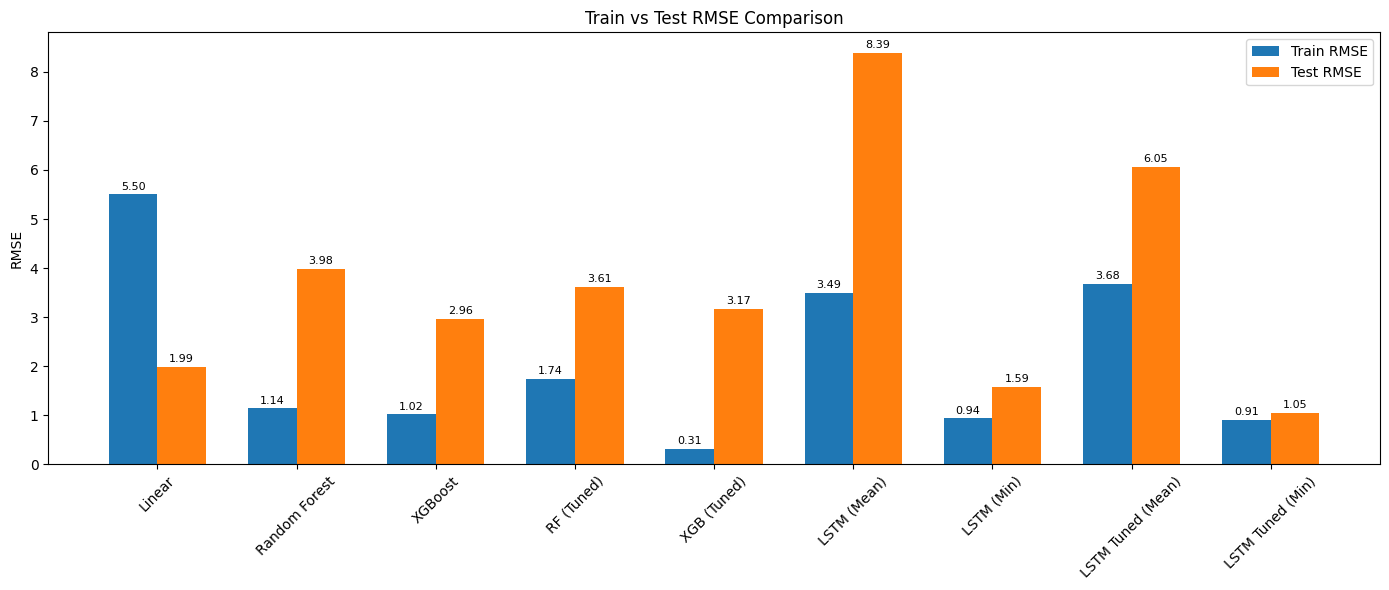

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create DataFrame
data = {
    "Model": [
        "Linear", "Random Forest", "XGBoost",
        "RF (Tuned)", "XGB (Tuned)",
        "LSTM (Mean)", "LSTM (Min)",
        "LSTM Tuned (Mean)", "LSTM Tuned (Min)"
    ],
    "Train_RMSE": [
        rmse_lr_train, rmse_rf_train,rmse_rf_best_train, rmse_xgb_train,
        rmse_xgb_best_train,
        results_df['Train_RMSE'].mean(), results_df['Train_RMSE'].min(),
        results_df_tuned['Train_RMSE'].mean(), results_df_tuned['Train_RMSE'].min()
    ],
    "Test_RMSE": [
        rmse_lr, rmse_rf, rmse_rf_best, rmse_xgb,
        rmse_xgb_best,
        results_df['Test_RMSE'].mean(), results_df['Test_RMSE'].min(),
        results_df_tuned['RMSE'].mean(), results_df_tuned['RMSE'].min()
    ],
    "Train_MAE": [
        mae_lr_train, mae_rf_train, mae_rf_best_train, mae_xgb_train,
        mae_xgb_best_train,
        results_df['Train_MAE'].mean(), results_df['Train_MAE'].min(),
        results_df_tuned['Train_MAE'].mean(), results_df_tuned['Train_MAE'].min()
    ],
    "Test_MAE": [
        mae_lr, mae_rf, mae_rf_best, mae_xgb,
        mae_xgb_best,
        results_df['Test_MAE'].mean(), results_df['Test_MAE'].min(),
        results_df_tuned['MAE'].mean(), results_df_tuned['MAE'].min()
    ],
    "Train_R2": [
        r2_lr_train, r2_rf_train, r2_rf_best_train,r2_xgb_train,
        r2_xgb_best_train,
        results_df['Train_R2'].mean(), results_df['Train_R2'].min(),
        results_df_tuned['Train_R2'].mean(), results_df_tuned['Train_R2'].min()
    ],
    "Test_R2": [
        r2_lr, r2_rf, r2_rf_best, r2_xgb,
        r2_xgb_best,
        results_df['Test_R2'].mean(), results_df['Test_R2'].min(),
        results_df_tuned['R2'].mean(), results_df_tuned['R2'].min()
    ]
}

df_metrics = pd.DataFrame(data)
display(df_metrics)


# Plot RMSE as grouped bar chart
bar_width = 0.35
x = np.arange(len(df_metrics['Model']))

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width/2, df_metrics['Train_RMSE'], width=bar_width, label='Train RMSE')
plt.bar(x + bar_width/2, df_metrics['Test_RMSE'], width=bar_width, label='Test RMSE')

# Annotate values on top of bars
for i, v in enumerate(df_metrics['Train_RMSE']):
    plt.text(i - bar_width/2, v + 0.1, f"{v:.2f}", ha='center', fontsize=8)
for i, v in enumerate(df_metrics['Test_RMSE']):
    plt.text(i + bar_width/2, v + 0.1, f"{v:.2f}", ha='center', fontsize=8)

plt.xticks(x, df_metrics['Model'], rotation=45)
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# Existing tuned model prediction
best_model = tuner.get_best_models(1)[0]
y_pred = best_model.predict(X_val).flatten()

from pandas.tseries.offsets import BDay
import pandas as pd
import numpy as np
from datetime import datetime

from pandas.tseries.offsets import BDay
import pandas as pd
import numpy as np
from datetime import datetime

forecast_horizon = 7
lookback = 21
today = pd.to_datetime(datetime.today().date())

#
if today.weekday() >= 5:  # Saturday (5) or Sunday (6)
    last_valid_date = today - BDay(1)
else:
    last_valid_date = today

future_predictions = []

for ticker in df['Ticker'].unique():
    print(f"\n📈 Forecasting next {forecast_horizon} business days for: {ticker}")

    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)
    df_ticker.dropna(inplace=True)

    # Scale features
    scaled_features = scaler.transform(df_ticker[features])
    last_seq = scaled_features[-lookback:]
    last_close = df_ticker['Close'].iloc[-1]

    # Generate next 7 *
    future_dates = pd.date_range(start=last_valid_date + BDay(1), periods=forecast_horizon, freq=BDay())

    seq = last_seq.copy()
    predicted_prices = []
    predicted_returns = []

    for step in range(forecast_horizon):
        input_seq = np.expand_dims(seq, axis=0)
        pred_return = best_model.predict(input_seq, verbose=0)[0][0]
        predicted_returns.append(pred_return)

        next_price = last_close * (1 + pred_return)
        predicted_prices.append(next_price)

        # Use previous features
        new_row = seq[-1].copy()
        seq = np.vstack([seq[1:], new_row])
        last_close = next_price

    # Store predictions
    pred_df = pd.DataFrame({
        "Ticker": [ticker] * forecast_horizon,
        "Date": future_dates,
        "Predicted_Close": predicted_prices,
        "Predicted_Return": predicted_returns,
    })

    future_predictions.append(pred_df)

# Combine and save
final_future_df = pd.concat(future_predictions, ignore_index=True)
final_future_df.to_csv("future_7day_prices.csv", index=False)

print(" Saved future_7day_prices.csv")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

📈 Forecasting next 7 business days for: EEM

📈 Forecasting next 7 business days for: GLD

📈 Forecasting next 7 business days for: QQQ

📈 Forecasting next 7 business days for: SPY

📈 Forecasting next 7 business days for: TLT

📈 Forecasting next 7 business days for: VEA

📈 Forecasting next 7 business days for: VNQ

📈 Forecasting next 7 business days for: VTI

📈 Forecasting next 7 business days for: XLF

📈 Forecasting next 7 business days for: XLV
 Saved future_7day_prices.csv
